<h1><center>Fitbit Data Transformation, Wrangling and Visualization</center></h1>


![Airbnb Logo](https://www.dcrainmaker.com/images/2020/04/Fitbit-Charge-4-Review-1280x720.jpg)

<h2><center>By Ibtassam Rasheed</center></h2>

### [Data Story link](https://www.notion.so/ibtassam/My-incomplete-journey-to-fitness-Visualized-with-Fitbit-data-04102c83a9cb472580ce03f4f15afffb#e6cfcd1b7ad346d8b6339b4b2c5eebd9)  | [My Tableau Public Profile](https://public.tableau.com/app/profile/ibtassam)

## Table of Contents

* [Introduction](#zero-bullet)
* [Data Transformation (json to csv)](#first-bullet)
* [Data Wrangling](#second-bullet)
* [Aggregation, data merging & exporting CSVs](#third-bullet)
* [Data Visualization (Matplotlib & Seaborn)](#fourth-bullet)
* [ML model](#fifth-bullet)
* [References](#sixth-bullet)

## Introduction <a class="anchor" id="zero-bullet"></a>

The rough sketch is as below:


Data for this analysis was sourced from my online Fitbit account for the years 2021 & 2022. If not exporting data for last 30 days only, FitBit does not provided tabular data. As I needed two years’ worth of data, I downloaded most of the data in the form of individual JSON files for each health metric with varying levels of sub-nesting. 

This nested JSON data was transformed to dataframes & CSVs and also grouped together. A lot of data cleaning and wrangling was also carried out. Finally, some visuals were created in Matplotlib and some in Tableau. The story link above will have both analyses combined in one place. The last section also applied some ML algorithms to predict the best features affecting a 'deep' sleep and a better 'sleep score'. Let's dive in.

## Data Transformation (JSON to CSV) <a class="anchor" id="first-bullet"></a>

In [1]:
# Importing necessary libraries

import pandas as pd
import numpy as np
import glob
import warnings
warnings.filterwarnings("ignore")

In [2]:
# These functions assist us in the JSON to CSV transformation.

def convert_json_to_df(file_list = []):
    df_list = []
    for json_file in file_list:
        df_list.append(pd.read_json(json_file))
    df = pd.concat(df_list)
    return df

def outer_merge(df1,df2):
    merged = pd.merge(df1, df2,how='outer', on='dateTime')
    return merged

def create_new_value(x='',column_name=''):
    try:
        x = x[column_name]
    except Exception as e:
        print(e)
        x = 0.0
    return x


In [3]:
# This section creates file lists of the JSON files in the directory

heart_rate_file_list = glob.glob('Physical-Activity/heart_rate-*')
steps_file_list = glob.glob('Physical-Activity/steps-*')
calories_file_list = glob.glob('Physical-Activity/calories-*')
sedentry_file_list = glob.glob('Physical-Activity/sedentary_minutes-*')
distance_file_list = glob.glob('Physical-Activity/distance-*')
very_activemins_file_list = glob.glob('Physical-Activity/very_active_minutes-*')
mod_activemins_file_list = glob.glob('Physical-Activity/moderately_active_minutes-*')
light_activemins_file_list = glob.glob('Physical-Activity/lightly_active_minutes-*')
time_in_heart_rate_zones_file_list = glob.glob('Physical-Activity/time_in_heart_rate_zones-*')
sleep_time_and_divisions_file_list = glob.glob('Sleep-Data/sleep-*')
resting_heart_rate_file_list = glob.glob('Physical-Activity/resting_heart_rate-*')
weight_file_list = glob.glob('Weight/weight-*')

In [4]:
# Reading various designs of JSONs into dataframes

# Heart rate  
# (This is in ~5 second granularities)
heart_rate_df = convert_json_to_df(file_list = heart_rate_file_list).reset_index()
# Heart rate data contains nested json that needed to be accessed by explicit assignment.
heart_rate_df['bpm'] = heart_rate_df['value'].transform(lambda x: create_new_value(x,'bpm'))
heart_rate_df = heart_rate_df.drop(['value','index'],axis=1)

# Steps
# (This is in minute by minute granularity)
steps_df = convert_json_to_df(file_list = steps_file_list).rename(columns={'value': 'steps'})

# Calories
# (This is in minute by minute granularity)
calories_df = convert_json_to_df(file_list = calories_file_list).rename(columns={'value': 'calories'})

# Sedentary minutes
# (This is in daily granularity)
sedentary_df = convert_json_to_df(file_list = sedentry_file_list).rename(columns={'value': 'sedentary mins'})

# Active mins
# (These are in daily granularity)
very_activemins_df = convert_json_to_df(file_list = very_activemins_file_list).rename(columns={'value': 'very active mins'})
mod_activemins_df = convert_json_to_df(file_list = mod_activemins_file_list).rename(columns={'value': 'mod active mins'})
light_activemins_df = convert_json_to_df(file_list = light_activemins_file_list).rename(columns={'value': 'light active mins'})

# Distance
# (This is in minute by minute granularity)
distance_df = convert_json_to_df(file_list = distance_file_list).rename(columns={'value': 'distance'})

# Resting Heart rate
# (This is in daily granularity)
restingHR_df = convert_json_to_df(file_list = resting_heart_rate_file_list).rename(columns = {'value' : 'Resting heart rate'})
# Due to nested structure of JSON, I used Regexp pattern to extract the heart rate only.
pattern_rhr = ".*value\':\s*(\d+)"
restingHR_df = pd.concat([restingHR_df.iloc[:,:1],
                              restingHR_df['Resting heart rate'].astype(str).str.extract(pattern_rhr, expand=False)
                             ],axis=1)
# Weight
# (This was manually entered by me on the app from time to time and is in daily granularity)
weight_df = convert_json_to_df(file_list = weight_file_list).rename(columns = {'date' : 'date', 'weight' : 'weight'})
weight_df = pd.concat([weight_df.date, weight_df.weight], axis = 1)

# Active zone minutes
# (This is in daily granularity)
active_zones_df = convert_json_to_df(file_list = time_in_heart_rate_zones_file_list).reset_index()
# 'Time in active zones' contains a sub json that require some Python magic to separate.
active_zones_df = pd.concat([active_zones_df.iloc[:,:2], active_zones_df.value.apply(pd.Series)],axis=1)
active_zones_df2 = pd.concat([active_zones_df.iloc[:,:2], active_zones_df.valuesInZones.apply(pd.Series)],axis=1)

# Sleep time & divisions
# (This is in daily granularity with multiple parameters, some nested)
sleep_divisions = convert_json_to_df(file_list = sleep_time_and_divisions_file_list).reset_index()
## Sleep data file contains a sub json that are explicitly converted into column
sleep_divisions = sleep_divisions.drop(['index','logId','logType','mainSleep', 'efficiency', 'type', 'infoCode'],axis=1)
sleep_divisions = pd.concat([sleep_divisions.iloc[:,:9], sleep_divisions.levels.apply(pd.Series)],axis=1)
sleep_divisions = sleep_divisions.drop(['data','shortData'],axis=1)
sleep_divisions2 = pd.concat([sleep_divisions.iloc[:,:9], sleep_divisions.summary.apply(pd.Series)],axis=1)
sleep_divisions2 = sleep_divisions2.drop(['restless','awake','asleep'],axis=1)
# Using Regexp pattern to extract only the minutes in each sleep stage
pattern_mins = ".*minutes\':\s*(\d+)"
sleep_divisions3 = pd.concat([sleep_divisions.iloc[:,:9],
                              sleep_divisions2['deep'].astype(str).str.extract(pattern_mins, expand=False),
                              sleep_divisions2['wake'].astype(str).str.extract(pattern_mins, expand=False),
                              sleep_divisions2['light'].astype(str).str.extract(pattern_mins, expand=False),
                              sleep_divisions2['rem'].astype(str).str.extract(pattern_mins, expand=False)
                             ],axis=1)


# Merging some of the metrics that have identical granularities at this stage
steps_and_calories = outer_merge(steps_df,calories_df)
sedentary_and_active_mins = outer_merge(sedentary_df,light_activemins_df)
sedentary_and_active_mins = outer_merge(sedentary_and_active_mins,mod_activemins_df)
sedentary_and_active_mins = outer_merge(sedentary_and_active_mins,very_activemins_df)


In [5]:
# #CSV files creation (if needed)
# heart_rate_df.to_csv('heartrate.csv') #6,086,601 rows
# steps_and_calories.to_csv('steps_and_calories.csv') #405,641 rows for steps and 1,141,888 rows for calories
# sedentary_and_active_mins.to_csv('sedentary_and_activemins.csv') #810 rows each
# distance_df.to_csv('distance.csv') #405,640 rows
# restingHR_df.to_csv('restingheartrate.csv') #1095 rows
# weight_df.to_csv('weight.csv') #24 rows
# active_zones_df2.to_csv('time_in_HR_zones.csv') #668 rows
# sleep_divisions3.to_csv('sleep_divisions.csv') #715 rows for all df (sleep states only have 557 rows)

In [6]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Data wrangling <a class="anchor" id="second-bullet"></a>

Now that we have created tabular data and been able to further analyze the various type of granularities. It is time to filter the data to 2021 and 2022. We will also aggregate the data where necessary to first get a table of daily fitness data.

In [7]:
# Converting 5-second granular data to daily values for each df

heart_rate_df['Date']= heart_rate_df['dateTime'].dt.date
heart_rate_df2 = heart_rate_df.drop(['dateTime'], axis=1)
cols = heart_rate_df2.columns.tolist()
cols = cols[-1:] + cols[:-1]
heart_rate_df2 = heart_rate_df2[cols]
heart_rate_df2['Date'] = pd.to_datetime(heart_rate_df2['Date'], errors='coerce')
heart_rate_df3 = heart_rate_df2.groupby(heart_rate_df2['Date'].dt.date)[['bpm']].median().reset_index()
# difference of ~ +1 bpm if I mean during the grouping. 668 days of values
heart_rate_df3['Date'] = pd.to_datetime(heart_rate_df3['Date'], errors='coerce')
heart_rate_df3 = heart_rate_df3[(heart_rate_df3['Date'] >= "2021-01-01") & (heart_rate_df3['Date'] <= "2022-12-31")]
heart_rate_df3['bpm'] = heart_rate_df3['bpm'].astype(int)
heart_rate_df3.head() #605 rows

,Date,bpm
43,2021-01-01,75
44,2021-01-02,76
45,2021-01-03,78
46,2021-01-04,78
47,2021-01-05,79


In [8]:
# same conversion for steps_and_calories
steps_and_calories['Date']= steps_and_calories['dateTime'].dt.date
steps_and_calories = steps_and_calories.drop(['dateTime'], axis=1)
cols = steps_and_calories.columns.tolist()
cols = cols[-1:] + cols[:-1]
steps_and_calories = steps_and_calories[cols]
steps_and_calories['Date'] = pd.to_datetime(steps_and_calories['Date'], errors='coerce')
steps_and_calories2 = steps_and_calories.groupby(steps_and_calories['Date'].dt.date)[['steps','calories']].sum().reset_index()
# for steps and calories, it made sense to sum all those granular values collected every minute
steps_and_calories2['Date'] = pd.to_datetime(steps_and_calories2['Date'], errors='coerce')
steps_and_calories2 = steps_and_calories2[(steps_and_calories2['Date'] >= "2021-01-01") & (steps_and_calories2['Date'] <= "2022-12-31")]
steps_and_calories2 = steps_and_calories2.reset_index(drop=True).round()
steps_and_calories2['steps'] = steps_and_calories2['steps'].astype(int)
steps_and_calories2['calories'] = steps_and_calories2['calories'].astype(int)
steps_and_calories2.head() #730 rows

,Date,steps,calories
0,2021-01-01,3759,2348
1,2021-01-02,5606,2554
2,2021-01-03,5079,2682
3,2021-01-04,3236,2595
4,2021-01-05,1220,2055


In [9]:
sedentary_and_active_mins = sedentary_and_active_mins.rename({'dateTime': 'Date'}, axis=1)
sedentary_and_active_mins2 = sedentary_and_active_mins[(sedentary_and_active_mins['Date'] >= "2021-01-01") & (sedentary_and_active_mins['Date'] <= "2022-12-31")]
sedentary_and_active_mins2 = sedentary_and_active_mins2.reset_index(drop=True)
sedentary_and_active_mins2 = sedentary_and_active_mins2.sort_values(by='Date', inplace = False) 
sedentary_and_active_mins2.head()  # 730 rows

,Date,sedentary mins,light active mins,mod active mins,very active mins
450,2021-01-01,685,169,0,0
451,2021-01-02,791,204,13,0
452,2021-01-03,699,247,0,0
453,2021-01-04,871,139,4,29
454,2021-01-05,581,56,0,0


In [10]:
# same conversion for distance_df
distance_df['Date']= distance_df['dateTime'].dt.date
distance_df = distance_df.drop(['dateTime'], axis=1)
cols = distance_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
distance_df = distance_df[cols]
distance_df['Date'] = pd.to_datetime(distance_df['Date'], errors='coerce')
distance_df2 = distance_df.groupby(distance_df['Date'].dt.date)[['distance']].sum().reset_index()
# for steps and calories, it made sense to sum all those granular values collected every minute
distance_df2['Date'] = pd.to_datetime(distance_df2['Date'], errors='coerce')
distance_df2 = distance_df2[(distance_df2['Date'] >= "2021-01-01") & (distance_df2['Date'] <= "2022-12-31")]
distance_df2 = distance_df2.reset_index(drop=True)
distance_df2['distance'] = (distance_df2['distance']/100000).round(1)
distance_df2.head() #730 rows

,Date,distance
0,2021-01-01,2.80
1,2021-01-02,4.10
2,2021-01-03,3.70
3,2021-01-04,2.30
4,2021-01-05,0.80


In [11]:
restingHR_df = restingHR_df.rename({'dateTime': 'Date'}, axis=1)
restingHR_df2 = restingHR_df[(restingHR_df['Date'] >= "2021-01-01") & (restingHR_df['Date'] <= "2022-12-31")]
restingHR_df2 = restingHR_df2.reset_index(drop=True)
restingHR_df2 = restingHR_df2.sort_values(by='Date', inplace = False) 
restingHR_df2.head()  # 730 rows

,Date,Resting heart rate
0,2021-01-01,70
1,2021-01-02,68
2,2021-01-03,69
3,2021-01-04,71
4,2021-01-05,73


In [12]:
weight_df2 = weight_df.rename({'date': 'Date'}, axis=1)
weight_df2['weight'] = (weight_df2['weight']* 0.453592).round(1) #convert lbs to kg
weight_df2 = weight_df2[(weight_df2['Date'] >= "2021-01-01") & (weight_df2['Date'] <= "2022-12-31")]
weight_df2 = weight_df2.reset_index(drop=True).sort_values(by='Date', inplace = False)
weight_dict = {"Date": "2022-12-30", "weight": 80.5}
df1 = pd.DataFrame(weight_dict, index=[16])
weight_df3 = pd.concat([weight_df2, df1]).reset_index(drop=True)
weight_df3['Date'] = pd.to_datetime(weight_df3['Date'], errors='coerce')
weight_df3.head()

,Date,weight
0,2021-01-01,81.70
1,2021-01-10,81.10
2,2021-02-16,79.90
3,2021-03-07,77.50
4,2021-04-01,75.60
5,2021-05-04,76.40
6,2021-05-09,75.60
7,2021-06-08,75.40
8,2021-07-27,75.70
9,2021-08-26,74.00


In [13]:
active_zones_df3 = active_zones_df2.rename({'dateTime': 'Date', 
                                            'IN_DEFAULT_ZONE_3':'Peak zone ( > 170 bpm)',
                                           'BELOW_DEFAULT_ZONE_1': 'Below Fat burn zone ( < 119 bpm)',
                                           'IN_DEFAULT_ZONE_2' : 'Cardio zone (142-170 bpm)',
                                           'IN_DEFAULT_ZONE_1' : 'Fat burn zone (119-142 bpm)'}, axis=1)
active_zones_df3 = active_zones_df3[(active_zones_df3['Date'] >= "2021-01-01") & (active_zones_df3['Date'] <= "2022-12-31")]
active_zones_df3 = active_zones_df3.drop(['index'], axis=1)
active_zones_df3 = active_zones_df3.sort_values(by='Date', inplace = False).reset_index(drop=True)
active_zones_df3 = active_zones_df3[['Date', 'Below Fat burn zone ( < 119 bpm)', 'Fat burn zone (119-142 bpm)',
                                    'Cardio zone (142-170 bpm)', 'Peak zone ( > 170 bpm)']].astype(int)
active_zones_df3['Date'] = pd.to_datetime(active_zones_df3['Date'])
active_zones_df3.head()  # 606 rows

,Date,Below Fat burn zone ( < 119 bpm),Fat burn zone (119-142 bpm),Cardio zone (142-170 bpm),Peak zone ( > 170 bpm)
0,2021-01-01,1393,38,0,0
1,2021-01-02,1215,73,0,0
2,2021-01-03,1293,129,0,0
3,2021-01-04,1315,82,19,2
4,2021-01-05,1407,23,0,0


In [14]:
sleep_divisions3 = sleep_divisions3.rename({'dateOfSleep': 'Date'}, axis=1)
sleep_divisions3['duration'] = (sleep_divisions3['duration']/60/60/1000).round(1) #convert ms to hrs
sleep_divisions3 = sleep_divisions3[(sleep_divisions3['Date'] >= "2021-01-01") & (sleep_divisions3['Date'] <= "2022-12-31")]
sleep_divisions3 = sleep_divisions3.reset_index(drop=True).sort_values(by='Date', inplace = False)
sleep_divisions3.head() #645 rows

,Date,startTime,endTime,duration,minutesToFallAsleep,minutesAsleep,minutesAwake,minutesAfterWakeup,timeInBed,deep,wake,light,rem
122,2021-01-01,2021-01-01T15:32:00.000,2021-01-01T16:58:30.000,1.40,0,80,6,0,86,NaN,NaN,NaN,NaN
123,2021-01-01,2021-01-01T01:00:30.000,2021-01-01T09:21:00.000,8.30,0,453,47,1,500,53,47,310,90
121,2021-01-02,2021-01-02T00:53:00.000,2021-01-02T08:05:00.000,7.20,0,369,63,0,432,86,63,198,85
120,2021-01-03,2021-01-03T00:39:30.000,2021-01-03T08:54:00.000,8.20,0,452,42,0,494,93,42,218,141
119,2021-01-04,2021-01-04T01:38:00.000,2021-01-04T08:15:00.000,6.60,0,369,28,0,397,81,28,187,101


## Aggregation, Data merging & exporting CSVs <a class="anchor" id="third-bullet"></a>

At this stage, most of the data sources have a consistent key in the form of 'Date' column. 2 years equate to 730 days. Most of the dataframes have 730 rows of data so I know in advance that the data should be merged to such dataframes to avoid null values in Date column. Now I will start to merge all of the dataframes.

It is important to note that this is still EDA phase of the data lifecycle so I will come back to transform data for other analyses, if needed. An example is converting heart rate data to hourly granularities.

In [104]:
from functools import reduce

all_df1 = [restingHR_df2, heart_rate_df3, active_zones_df3, steps_and_calories2, 
          distance_df2, sedentary_and_active_mins2]
fitness_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'],
                                            how='left'), all_df1)
fitness_merged.head()

,Date,Resting heart rate,bpm,Below Fat burn zone ( < 119 bpm),Fat burn zone (119-142 bpm),Cardio zone (142-170 bpm),Peak zone ( > 170 bpm),steps,calories,distance,sedentary mins,light active mins,mod active mins,very active mins
0,2021-01-01,70,75.00,1393.00,38.00,0.00,0.00,3759,2348,2.80,685,169,0,0
1,2021-01-02,68,76.00,1215.00,73.00,0.00,0.00,5606,2554,4.10,791,204,13,0
2,2021-01-03,69,78.00,1293.00,129.00,0.00,0.00,5079,2682,3.70,699,247,0,0
3,2021-01-04,71,78.00,1315.00,82.00,19.00,2.00,3236,2595,2.30,871,139,4,29
4,2021-01-05,73,79.00,1407.00,23.00,0.00,0.00,1220,2055,0.80,581,56,0,0


In [105]:
fitness_merged.describe() # Getting a picture of how the merged dataframe looks at this point

,bpm,Below Fat burn zone ( < 119 bpm),Fat burn zone (119-142 bpm),Cardio zone (142-170 bpm),Peak zone ( > 170 bpm),steps,calories,distance,sedentary mins,light active mins,mod active mins,very active mins
count,605.00,606.00,606.00,606.00,606.00,730.00,730.00,607.00,730.00,730.00,730.00,730.00
mean,77.12,1133.66,126.68,3.95,0.15,3916.41,2305.31,3.43,979.87,128.00,11.83,9.51
std,5.79,290.49,128.26,10.20,0.87,3484.07,468.08,2.41,299.46,92.02,23.30,19.62
min,66.00,2.00,0.00,0.00,0.00,0.00,1656.00,0.00,289.00,0.00,0.00,0.00
25%,73.00,1031.00,40.00,0.00,0.00,1437.00,1969.25,1.80,749.00,65.00,0.00,0.00
50%,76.00,1236.50,92.00,0.00,0.00,3330.50,2248.50,2.80,864.00,127.00,0.00,0.00
75%,80.00,1335.50,165.75,3.00,0.00,5580.25,2546.25,4.40,1292.00,182.75,14.00,12.00
max,104.00,1429.00,1021.00,126.00,11.00,19901.00,4840.00,14.60,1440.00,529.00,232.00,186.00


In [106]:
fitness_merged.info() # Before compensating for missing values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 0 to 729
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Date                              730 non-null    datetime64[ns]
 1   Resting heart rate                730 non-null    object        
 2   bpm                               605 non-null    float64       
 3   Below Fat burn zone ( < 119 bpm)  606 non-null    float64       
 4   Fat burn zone (119-142 bpm)       606 non-null    float64       
 5   Cardio zone (142-170 bpm)         606 non-null    float64       
 6   Peak zone ( > 170 bpm)            606 non-null    float64       
 7   steps                             730 non-null    int64         
 8   calories                          730 non-null    int64         
 9   distance                          607 non-null    float64       
 10  sedentary mins                    730 non-null    

In [107]:
fitness_merged['bpm'] = fitness_merged['bpm'].fillna((fitness_merged['bpm'].mean())).astype(int)
fitness_merged['Below Fat burn zone ( < 119 bpm)'] = fitness_merged['Below Fat burn zone ( < 119 bpm)'].fillna((fitness_merged['Below Fat burn zone ( < 119 bpm)'].mean())).astype(int)
fitness_merged['Fat burn zone (119-142 bpm)'] = fitness_merged['Fat burn zone (119-142 bpm)'].fillna((fitness_merged['Fat burn zone (119-142 bpm)'].mean())).astype(int)
fitness_merged['Cardio zone (142-170 bpm)'] = fitness_merged['Cardio zone (142-170 bpm)'].fillna((fitness_merged['Cardio zone (142-170 bpm)'].mean())).astype(int)
fitness_merged['Peak zone ( > 170 bpm)'] = fitness_merged['Peak zone ( > 170 bpm)'].fillna((fitness_merged['Peak zone ( > 170 bpm)'].mean())).astype(int)
fitness_merged['distance'] = fitness_merged['distance'].fillna((fitness_merged['distance'].mean()))
fitness_merged['Resting heart rate'] = fitness_merged['Resting heart rate'].astype(int)
fitness_merged.head() # After compensating for missing values

,Date,Resting heart rate,bpm,Below Fat burn zone ( < 119 bpm),Fat burn zone (119-142 bpm),Cardio zone (142-170 bpm),Peak zone ( > 170 bpm),steps,calories,distance,sedentary mins,light active mins,mod active mins,very active mins
0,2021-01-01,70,75,1393,38,0,0,3759,2348,2.80,685,169,0,0
1,2021-01-02,68,76,1215,73,0,0,5606,2554,4.10,791,204,13,0
2,2021-01-03,69,78,1293,129,0,0,5079,2682,3.70,699,247,0,0
3,2021-01-04,71,78,1315,82,19,2,3236,2595,2.30,871,139,4,29
4,2021-01-05,73,79,1407,23,0,0,1220,2055,0.80,581,56,0,0


In [108]:
fitness_merged['Date'] = pd.to_datetime(fitness_merged['Date'])
fitness_merged['day_of_week'] = fitness_merged['Date'].dt.day_name()
fitness_merged.head()

,Date,Resting heart rate,bpm,Below Fat burn zone ( < 119 bpm),Fat burn zone (119-142 bpm),Cardio zone (142-170 bpm),Peak zone ( > 170 bpm),steps,calories,distance,sedentary mins,light active mins,mod active mins,very active mins,day_of_week
0,2021-01-01,70,75,1393,38,0,0,3759,2348,2.80,685,169,0,0,Friday
1,2021-01-02,68,76,1215,73,0,0,5606,2554,4.10,791,204,13,0,Saturday
2,2021-01-03,69,78,1293,129,0,0,5079,2682,3.70,699,247,0,0,Sunday
3,2021-01-04,71,78,1315,82,19,2,3236,2595,2.30,871,139,4,29,Monday
4,2021-01-05,73,79,1407,23,0,0,1220,2055,0.80,581,56,0,0,Tuesday


In [20]:
#fitness_merged.to_csv('fitness_merged.csv')

In [224]:
# An additional parameter I want to look at is heart rate hourly data. Let's create hourly granularity for HR.
heart_rate_df_hour = heart_rate_df.copy()
heart_rate_df_hour['dateTime'] = heart_rate_df_hour['dateTime'].dt.hour
heart_rate_df_hour = heart_rate_df_hour.rename({'dateTime':'Hour of day'}, axis=1)
heart_rate_df_hour2 = heart_rate_df_hour.copy()
heart_rate_df_hour2 = heart_rate_df_hour2.groupby([heart_rate_df_hour2.Date,heart_rate_df_hour2['Hour of day']]).bpm.median().reset_index()
heart_rate_df_hour2['Date'] = pd.to_datetime(heart_rate_df_hour2['Date'])
heart_rate_df_hour2 = heart_rate_df_hour2[(heart_rate_df_hour2['Date'] >= "2021-01-01") & (heart_rate_df_hour2['Date'] <= "2022-12-31")]
heart_rate_df_hour2 = heart_rate_df_hour2.reset_index(drop=True).sort_values(by='Date', inplace = False)
heart_rate_df_hour2 = heart_rate_df_hour2.sort_values(['Date','Hour of day'],ascending = [True, True])
heart_rate_df_hour2.head()

,Date,Hour of day,bpm
0,2021-01-01,0,68.00
1,2021-01-01,1,67.00
2,2021-01-01,2,67.00
3,2021-01-01,3,63.00
4,2021-01-01,4,68.00


In [55]:
#heart_rate_df_hour2.to_csv('hourly_heart_rate.csv')

In [22]:
# Let's start on first sleep divisions dataset (sleep minutes).
# Compensating for missing values in last 4 columns with mean values.
sleep_divisions3['deep'] = sleep_divisions3['deep'].fillna(0).astype(int)
sleep_divisions3['deep'] = sleep_divisions3['deep'].replace(0, sleep_divisions3['deep'].mean()).astype(int)
sleep_divisions3['wake'] = sleep_divisions3['wake'].fillna(0).astype(int)
sleep_divisions3['wake'] = sleep_divisions3['wake'].replace(0, sleep_divisions3['wake'].mean()).astype(int)
sleep_divisions3['light'] = sleep_divisions3['light'].fillna(0).astype(int)
sleep_divisions3['light'] = sleep_divisions3['light'].replace(0, sleep_divisions3['light'].mean()).astype(int)
sleep_divisions3['rem'] = sleep_divisions3['rem'].fillna(0).astype(int)
sleep_divisions3['rem'] = sleep_divisions3['rem'].replace(0, sleep_divisions3['rem'].mean()).astype(int)
sleep_divisions3.head()

,Date,startTime,endTime,duration,minutesToFallAsleep,minutesAsleep,minutesAwake,minutesAfterWakeup,timeInBed,deep,wake,light,rem
122,2021-01-01,2021-01-01T15:32:00.000,2021-01-01T16:58:30.000,1.40,0,80,6,0,86,57,40,173,68
123,2021-01-01,2021-01-01T01:00:30.000,2021-01-01T09:21:00.000,8.30,0,453,47,1,500,53,47,310,90
121,2021-01-02,2021-01-02T00:53:00.000,2021-01-02T08:05:00.000,7.20,0,369,63,0,432,86,63,198,85
120,2021-01-03,2021-01-03T00:39:30.000,2021-01-03T08:54:00.000,8.20,0,452,42,0,494,93,42,218,141
119,2021-01-04,2021-01-04T01:38:00.000,2021-01-04T08:15:00.000,6.60,0,369,28,0,397,81,28,187,101


In [23]:
sleep_divisions3['Date'] = pd.to_datetime(sleep_divisions3['Date'])
sleep_divisions3['day_of_week'] = sleep_divisions3['Date'].dt.day_name()
sleep_divisions3.head()

,Date,startTime,endTime,duration,minutesToFallAsleep,minutesAsleep,minutesAwake,minutesAfterWakeup,timeInBed,deep,wake,light,rem,day_of_week
122,2021-01-01,2021-01-01T15:32:00.000,2021-01-01T16:58:30.000,1.40,0,80,6,0,86,57,40,173,68,Friday
123,2021-01-01,2021-01-01T01:00:30.000,2021-01-01T09:21:00.000,8.30,0,453,47,1,500,53,47,310,90,Friday
121,2021-01-02,2021-01-02T00:53:00.000,2021-01-02T08:05:00.000,7.20,0,369,63,0,432,86,63,198,85,Saturday
120,2021-01-03,2021-01-03T00:39:30.000,2021-01-03T08:54:00.000,8.20,0,452,42,0,494,93,42,218,141,Sunday
119,2021-01-04,2021-01-04T01:38:00.000,2021-01-04T08:15:00.000,6.60,0,369,28,0,397,81,28,187,101,Monday


In [24]:
#sleep_divisions3.to_csv('sleep_divisions.csv')

In [25]:
# Let's work a bit on the second sleep dataset (sleep scores).
# Fortunately this came as a csv. We'll just verify its consistency.
sleep_score = pd.read_csv("/Users/ibtassam/Downloads/MyFitbitData/IbtassamR/Final datasets/Sleep-Data/sleep_score.csv")
sleep_score = sleep_score.rename({'timestamp': 'Date'}, axis=1)
sleep_score['Date'] = pd.to_datetime(sleep_score['Date'])
sleep_score2 = sleep_score[(sleep_score['Date'] >= "2021-01-01") & (sleep_score['Date'] <= "2022-12-31")]
sleep_score2['Date'] = sleep_score2['Date'].dt.date
sleep_score2['Date'] = pd.to_datetime(sleep_score2['Date'])
sleep_score2 = sleep_score2.reset_index(drop=True)
sleep_score2 = sleep_score2.sort_values(by='Date', inplace = False) 
sleep_score2['day_of_week'] = sleep_score2['Date'].dt.day_name()

In [26]:
sleep_score2.head()

,sleep_log_entry_id,Date,overall_score,composition_score,revitalization_score,duration_score,deep_sleep_in_minutes,resting_heart_rate,restlessness,day_of_week
484,30294452331,2021-01-01,84,19,23,42,52,72,0.07,Friday
483,30303729484,2021-01-02,74,21,18,35,86,70,0.13,Saturday
482,30319770509,2021-01-03,80,22,16,42,92,68,0.10,Sunday
481,30339669648,2021-01-04,77,21,17,39,80,69,0.05,Monday
480,30341872243,2021-01-05,77,22,11,44,105,71,0.14,Tuesday


In [27]:
#sleep_score2.to_csv('sleep_score.csv')

Now we have 3 distinct datasets; 1 for physical activity, 1 for sleep division by minutes and 1 for sleep scores. There's an array of analyses that can be run with this vast data but due to shortage of time, we will attempt few here on Python and few on Tableau. Let's see what we can find out of them.

Merging all datasets and EDA on the various parameters.

In [169]:
pd.set_option('display.max_columns', 500)
sleep_divisions4 = sleep_divisions3.drop_duplicates(subset=['Date'], keep='last')  
sleep_score3 = sleep_score2.drop_duplicates(subset=['Date'], keep='last')  
all_merged = fitness_merged.merge(sleep_divisions4, how = 'left', on='Date')
all_merged = all_merged.merge(sleep_score2, how = 'left', on= 'Date')
all_merged = all_merged.dropna().rename({'duration':'duration_of_sleep', 'distance':'distance_km'
                                        ,'Below Fat burn zone ( < 119 bpm)':'below_fat_burn_zone'
                                        , 'Fat burn zone (119-142 bpm)':'fat_burn_zone'
                                        , 'Cardio zone (142-170 bpm)': 'cardio_zone'
                                        , 'Peak zone ( > 170 bpm)':'peak_zone'}, axis=1)
all_merged = all_merged.drop(['day_of_week_x','startTime','endTime','day_of_week_y', 'sleep_log_entry_id'],axis=1)
all_merged['is_weekend'] = all_merged['Date'].dt.dayofweek > 4
all_merged['is_weekend'] = all_merged['is_weekend'].astype(int)
all_merged.head()

,Date,Resting heart rate,bpm,below_fat_burn_zone,fat_burn_zone,cardio_zone,peak_zone,steps,calories,distance_km,sedentary mins,light active mins,mod active mins,very active mins,duration_of_sleep,minutesToFallAsleep,minutesAsleep,minutesAwake,minutesAfterWakeup,timeInBed,deep,wake,light,rem,overall_score,composition_score,revitalization_score,duration_score,deep_sleep_in_minutes,resting_heart_rate,restlessness,day_of_week,is_weekend
0,2021-01-01,70,75,1393,38,0,0,3759,2348,2.80,685,169,0,0,8.30,0.00,453.00,47.00,1.00,500.00,53.00,47.00,310.00,90.00,84.00,19.00,23.00,42.00,52.00,72.00,0.07,Friday,0
1,2021-01-02,68,76,1215,73,0,0,5606,2554,4.10,791,204,13,0,7.20,0.00,369.00,63.00,0.00,432.00,86.00,63.00,198.00,85.00,74.00,21.00,18.00,35.00,86.00,70.00,0.13,Saturday,1
2,2021-01-03,69,78,1293,129,0,0,5079,2682,3.70,699,247,0,0,8.20,0.00,452.00,42.00,0.00,494.00,93.00,42.00,218.00,141.00,80.00,22.00,16.00,42.00,92.00,68.00,0.10,Sunday,1
3,2021-01-04,71,78,1315,82,19,2,3236,2595,2.30,871,139,4,29,6.60,0.00,369.00,28.00,0.00,397.00,81.00,28.00,187.00,101.00,77.00,21.00,17.00,39.00,80.00,69.00,0.05,Monday,0
4,2021-01-05,73,79,1407,23,0,0,1220,2055,0.80,581,56,0,0,1.60,0.00,97.00,2.00,0.00,99.00,57.00,40.00,173.00,68.00,77.00,22.00,11.00,44.00,105.00,71.00,0.14,Tuesday,0


In [170]:
all_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 485 entries, 0 to 740
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   485 non-null    datetime64[ns]
 1   Resting heart rate     485 non-null    int64         
 2   bpm                    485 non-null    int64         
 3   below_fat_burn_zone    485 non-null    int64         
 4   fat_burn_zone          485 non-null    int64         
 5   cardio_zone            485 non-null    int64         
 6   peak_zone              485 non-null    int64         
 7   steps                  485 non-null    int64         
 8   calories               485 non-null    int64         
 9   distance_km            485 non-null    float64       
 10  sedentary mins         485 non-null    int64         
 11  light active mins      485 non-null    int64         
 12  mod active mins        485 non-null    int64         
 13  very 

In [133]:
all_merged_avg = all_merged.groupby(['day_of_week']).mean().reset_index()
days = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
all_merged_avg = all_merged_avg.groupby(['day_of_week']).sum().reindex(days).reset_index()
all_merged_avg.head()

,day_of_week,Resting heart rate,bpm,Below Fat burn zone ( < 119 bpm),Fat burn zone (119-142 bpm),Cardio zone (142-170 bpm),Peak zone ( > 170 bpm),steps,calories,distance_km,sedentary mins,light active mins,mod active mins,very active mins,duration_of_sleep,minutesToFallAsleep,minutesAsleep,minutesAwake,minutesAfterWakeup,timeInBed,deep,wake,light,rem,overall_score,composition_score,revitalization_score,duration_score,deep_sleep_in_minutes,resting_heart_rate,restlessness
0,Monday,68.76,76.76,1207.79,143.35,5.30,0.18,5184.26,2492.50,3.79,786.36,165.86,16.17,13.89,7.06,0.00,374.06,49.33,1.44,423.56,70.23,51.68,229.59,83.39,76.68,19.53,19.42,37.73,69.11,70.00,0.09
1,Tuesday,69.93,76.68,1236.10,124.38,5.04,0.36,4716.36,2452.93,3.43,764.93,157.91,13.88,13.01,6.44,0.00,340.32,45.65,1.51,386.17,74.74,51.33,214.06,85.77,77.55,20.20,19.35,38.00,74.91,69.94,0.09
2,Wednesday,70.05,76.95,1213.32,136.43,4.57,0.16,4770.43,2456.56,3.46,784.89,167.63,13.87,9.59,6.37,0.00,337.53,44.15,1.28,381.87,68.33,48.92,216.03,80.08,76.21,19.39,19.29,37.53,70.12,69.81,0.09
3,Thursday,70.24,76.56,1210.87,123.56,3.59,0.08,4737.80,2409.80,3.45,799.21,154.62,12.13,10.15,6.78,0.00,359.00,47.70,1.94,406.77,74.11,51.97,219.20,90.56,77.38,20.04,19.27,38.07,74.14,70.08,0.10
4,Friday,69.88,76.68,1182.08,148.94,3.78,0.18,4497.26,2543.14,3.25,767.08,166.04,23.92,17.36,6.93,0.00,367.65,47.79,1.50,415.49,71.04,50.08,217.22,93.68,78.10,20.49,19.54,38.07,70.89,70.00,0.09


## Data Visualization (Matplotlib & Seaborn) <a class="anchor" id="fourth-bullet"></a>

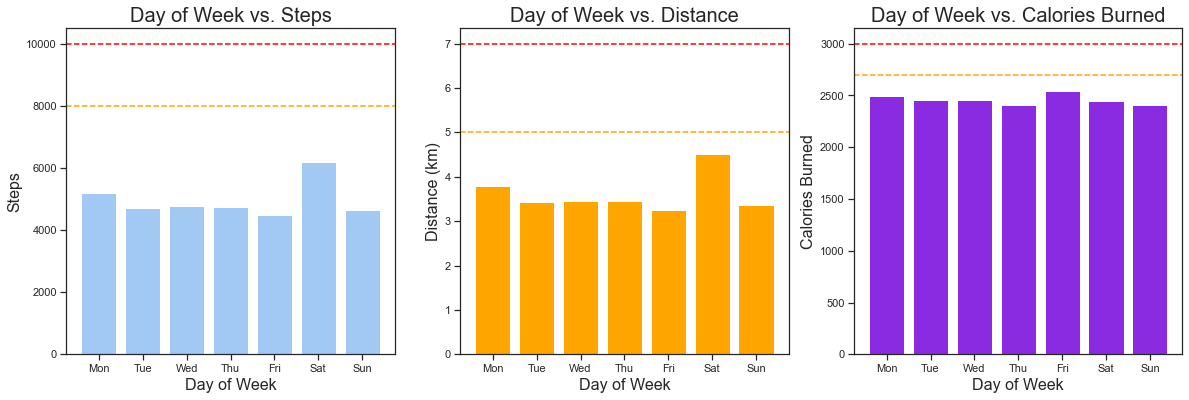

In [278]:
import matplotlib.pyplot as plt
minDayCodes = [ '','Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
fig = plt.figure(figsize = (20,6))
# 2021 and 2022 overall steps plot vs day of week
ax = plt.subplot(131)  
plt.bar(all_merged_avg.index, all_merged_avg['steps'])
plt.title('Day of Week vs. Steps', fontsize=20)
plt.xlabel('Day of Week', fontsize=16)
plt.ylabel('Steps', fontsize=16)
ax.axhline(8000, color="orange", linestyle='--')
ax.axhline(10000, color="red", linestyle='--')
ax.set_xticklabels(minDayCodes)
# 2021 and 2022 overall 'distance' plot vs day of week
ax2 = fig.add_subplot(132)
ax2.set_xticklabels(minDayCodes)
plt.bar(all_merged_avg.index, all_merged_avg['distance_km'], color='orange')
plt.title('Day of Week vs. Distance', fontsize=20)
plt.xlabel('Day of Week', fontsize=16)
plt.ylabel('Distance (km)', fontsize=16)
ax2.axhline(5, color="orange", linestyle='--')
ax2.axhline(7, color="red", linestyle='--')
# 2021 and 2022 overall calories burned plot vs day of week
ax3 = fig.add_subplot(133)
plt.bar(all_merged_avg.index, all_merged_avg['calories'], color='blueviolet')
plt.title('Day of Week vs. Calories Burned', fontsize=20)
plt.xlabel('Day of Week', fontsize=16)
plt.ylabel('Calories Burned', fontsize=16)
ax3.set_xticklabels(minDayCodes)
ax3.axhline(2700, color="orange", linestyle='--')
ax3.axhline(3000, color="red", linestyle='--')

plt.show()

In [158]:
import seaborn as sns
def getDayLabel(dayNum):
    return dayCodes[dayNum]

def plot_heatmap(corrmat, correlationOf, title, darkTheme=False):
    if darkTheme:
        sns.set(style='darkgrid', palette='deep') # Using Seaborn for making heatmap
        cmap="YlGnBu"
    else:     
        sns.set(style = "white")
        cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corrmat, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Draw the heatmap with the mask and correct aspect ratio
    plt.figure(figsize=(10, 10))
    hm = sns.heatmap(corrmat, mask=mask, cbar=True, annot=True, square=True, fmt='.2f', 
                 annot_kws={'size': 10}, cmap=cmap)
    hm.set_title(title)
    plt.yticks(rotation=0)
    plt.show()

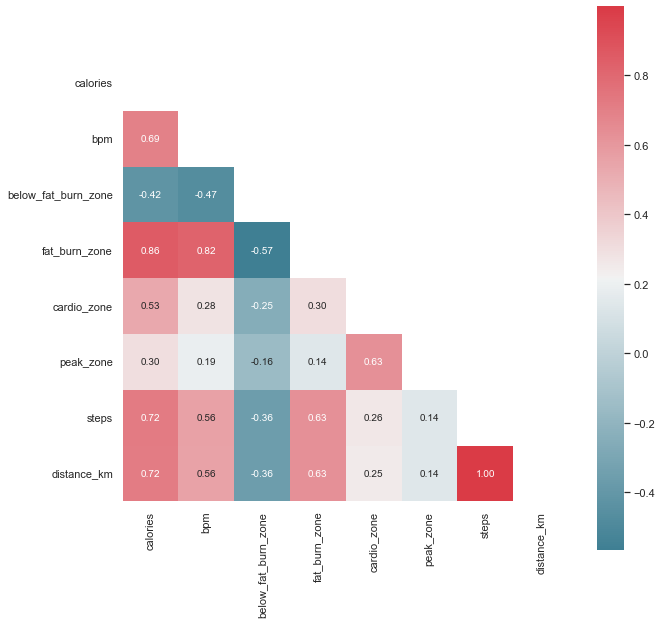

In [159]:
correlationOf = 'Calories Burned'
corrdf_calories = all_merged[['calories','bpm','below_fat_burn_zone', 'fat_burn_zone', 'cardio_zone',
                             'peak_zone', 'steps', 'distance_km']]
plot_heatmap(corrdf_calories.corr(), correlationOf, '')

There are some really good insights here. <br>
- Higher calories have strong positive correlation with heart rate, being in the 'fat burn zone' range of heart beats, number of steps and the distance covered.
- Also, we see that heart beat has strong negative correlation with being in the 'below fat burn zone' range of heart beat. We also notice strong positive correlation between being in 'fat burn zone' range of heart beat and the number of steps & distance covered. 

These findings are mostly already understood. Let's see some more correlations.

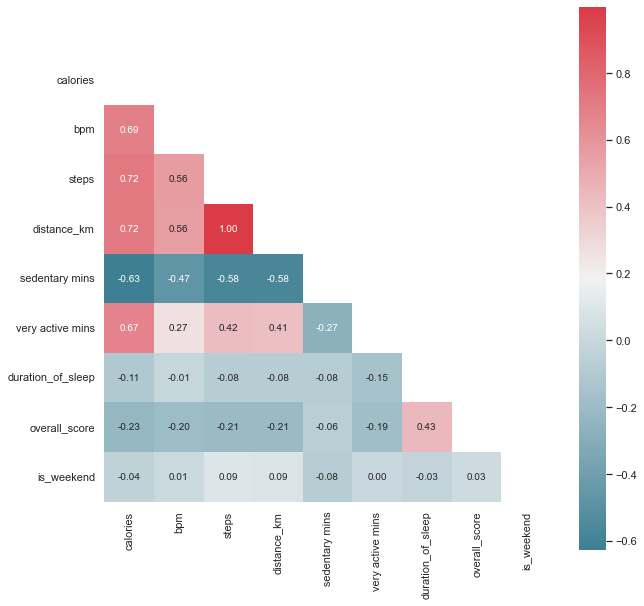

In [171]:
correlationOf = 'Calories Burned'
corrdf_calories = all_merged[['calories','bpm'
                              , 'steps', 'distance_km','sedentary mins','very active mins',
                             'duration_of_sleep', 'overall_score','is_weekend']]
plot_heatmap(corrdf_calories.corr(), correlationOf, '')

We add in a few new variables and build on our previous insights. <br>
- Number of calories burned is strongly negative correlated with 'sedentary minutes' (doing nothing awake/ sleeping). <br>
- We also notice slight negative correlation between calories burned and sleep duration as well as 'sleep score' calculated by fitbit.<br>
- There are a lot of obvious correlations like; Number of steps is positively correlated with distance covered & 'very active mins' but negatively with sedentary mins. <br> 

Let's keep going. I am really interested in knowing correlation between exercise parameters and sleep parameters.

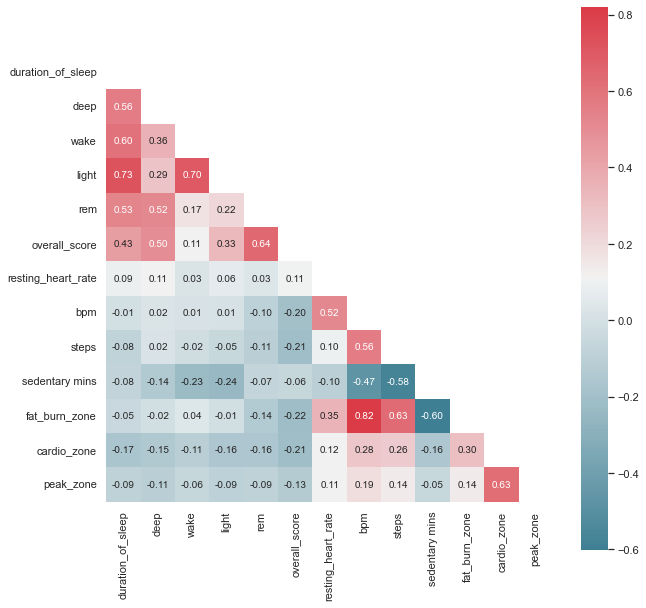

In [173]:
correlationOf = 'Exercise vs Sleep'
corrdf_sleep = all_merged[['duration_of_sleep','deep','wake','light','rem','overall_score','resting_heart_rate',
                              'bpm', 'steps','sedentary mins','fat_burn_zone','cardio_zone','peak_zone']]
plot_heatmap(corrdf_sleep.corr(), correlationOf, '')

Finally, I notice some surprises. I was thinking we will notice strong correlation between the 'duration of sleep' and physical activity parameters. <br>
However, as per my data, there is very weak correlation as can be seen from 1st column of this chart.

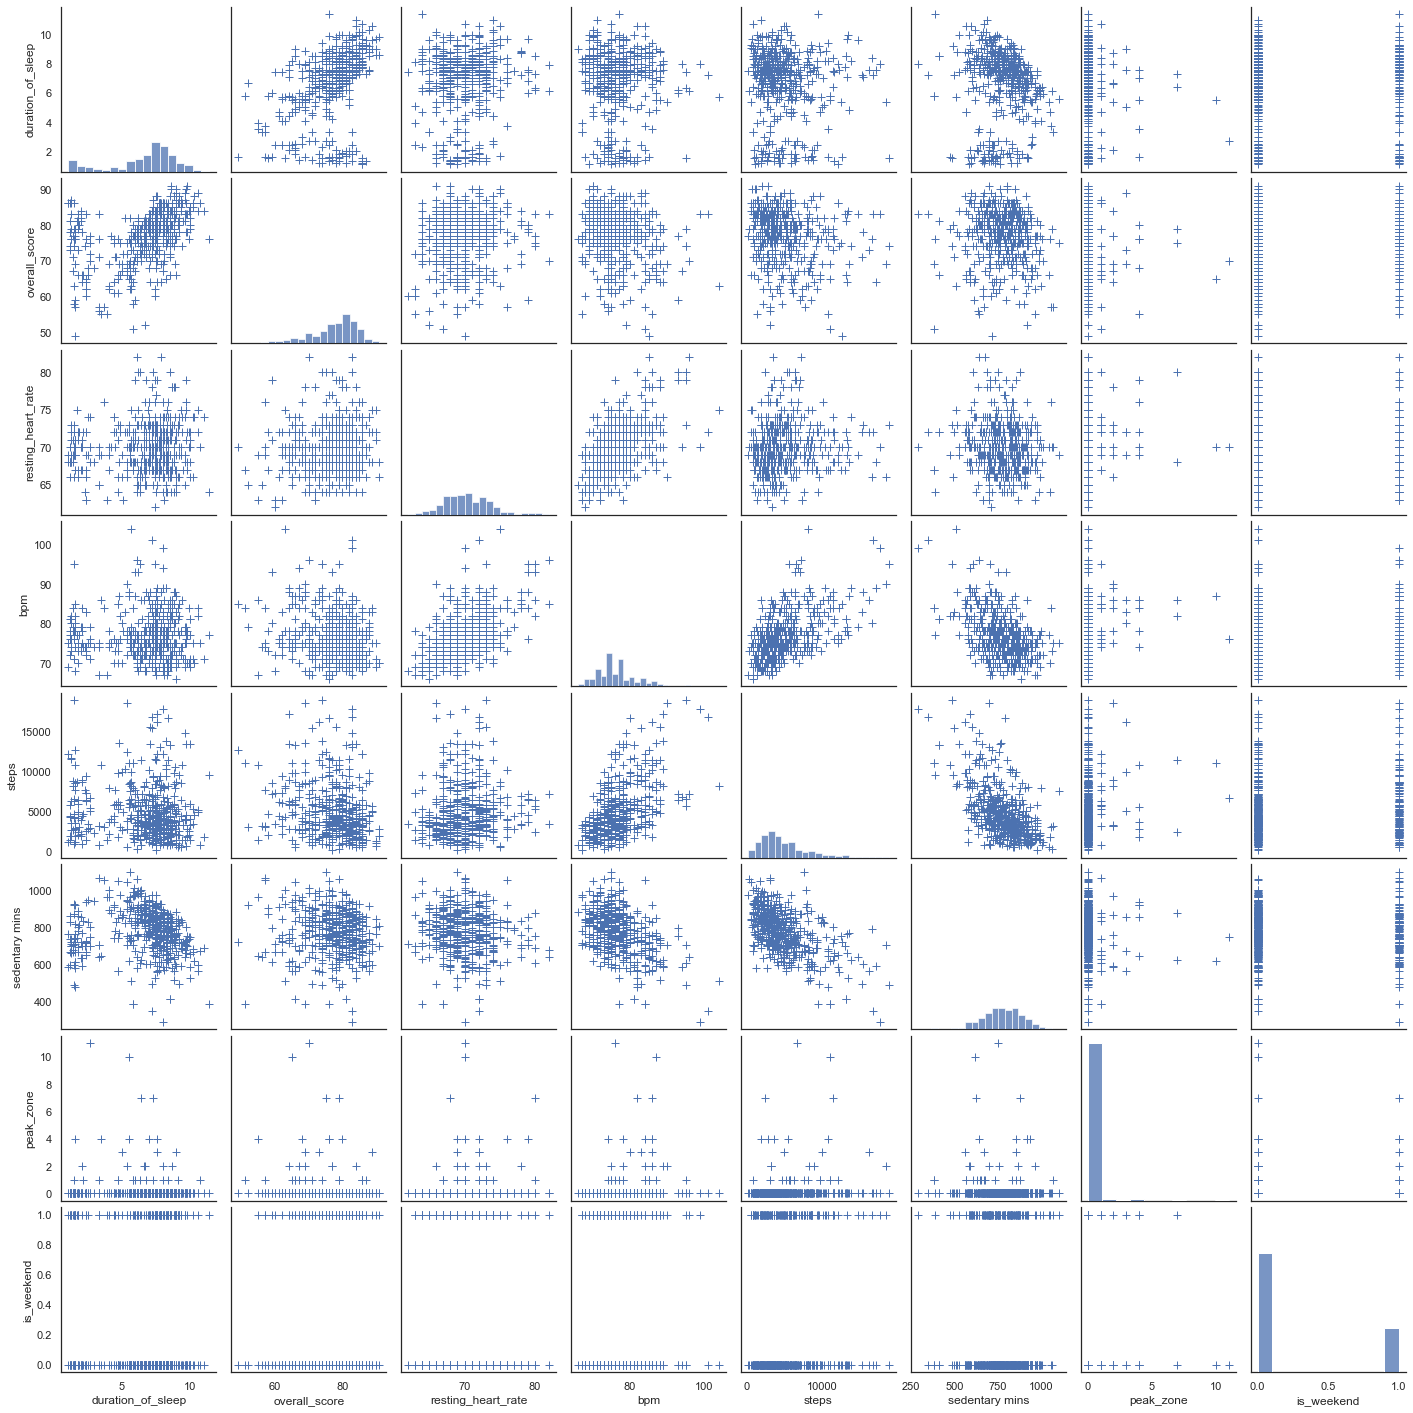

In [174]:
# Basic correlogram
corrdf_sleep2 = all_merged[['duration_of_sleep','overall_score','resting_heart_rate',
                              'bpm', 'steps','sedentary mins','peak_zone','is_weekend']]
sns.pairplot(corrdf_sleep2, kind="scatter", markers="+", plot_kws=dict(s=50, edgecolor="b", linewidth=1))
plt.show()

We get a different depiction of our correlation. We also notice how there is slight skewness of sedentary minutes on weekend, which is understandable.

,count,mean,std,min,25%,50%,75%,max
timeInBed,645.00,6.11,2.64,1.02,4.07,7.00,8.02,11.42


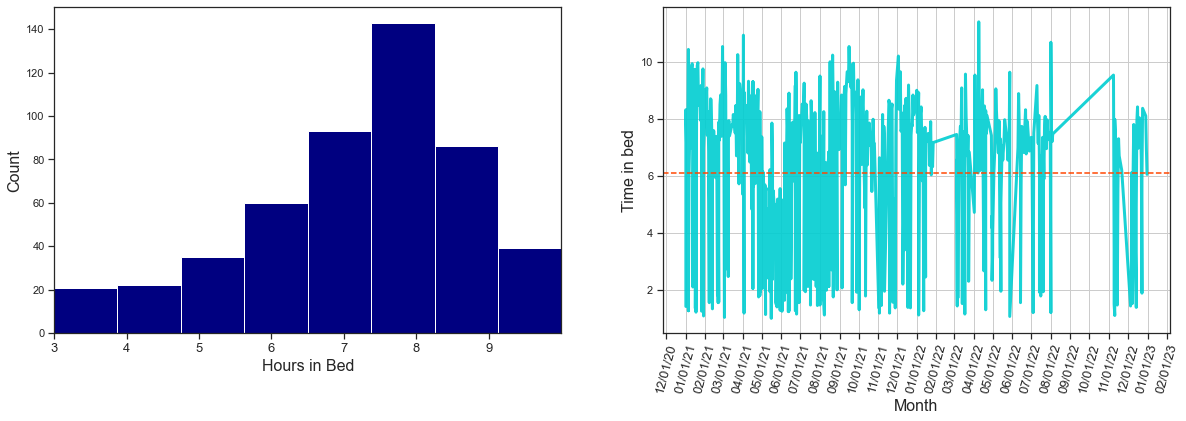

In [291]:
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator, DateFormatter

sleepDesc = pd.DataFrame(sleep_divisions3['timeInBed']/60).describe().transpose()
avgSleepHours = round(sleepDesc.at['timeInBed','mean'],2)
#summary = 'Averaging a sleep of {} hours with a deviation of {} hours'.format(avgSleepHours, round(sleepDesc.at['timeInBed','std'],2))
hoursInBed = sleep_divisions3['timeInBed']/60

fig = plt.figure(figsize = (20,6))

ax = plt.subplot(121)  
plt.hist(hoursInBed, bins = 8, range = (3, 10), color="navy")
plt.xlim(3, 10)
plt.xticks(range(3, 10), fontsize = 13)
plt.xlabel('Hours in Bed', fontsize=16)
plt.ylabel('Count', fontsize=16);
#plt.title(summary, fontsize=15)

#############

ax2 = fig.add_subplot(122)
plt.plot(sleep_divisions3['Date'],hoursInBed, linestyle='-', 
         markersize=10, color='darkturquoise', label='% Light', linewidth=3.0, alpha=0.9)
plt.xlabel('Month', fontsize=16)
plt.ylabel('Time in bed', fontsize=16)
ax2.axhline(avgSleepHours, color="orangered", linestyle='--')
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%D'))
ax2.grid(True)
plt.xticks(rotation=75, fontsize = 13)
plt.plot()

sleepDesc

This result gives me a significant clue about my sleeping pattern. I try to sleep 8 hours which I have believed to be the magic number for me. However, the average of 6 hours is disappointing. The standard deviation of 2.6 hours either way is also a bad sign. It shows volatility in my sleep durations. Lot to work on. <br>
It is also important to note that sleep data may not be as reliable as the physical activity data. I have notice many a times that my Fitbit recorded far less sleep when I woke up. The chart on the right shows a lot of values below 2 hours. Although, this may be partially justifiable for 2021 due to the nature of my work at the time but it is hard to understand for 2022. <br> 
We may also ignore the two periods in 2022 when data was not recorded by the fitbit.



In [194]:
import datetime
def is_nan(x):
    return (x is np.nan or x != x)

def defineSleepBucket(row):
    sleepEntry = row['startTime']
    if not is_nan(sleepEntry):
        sleepTimeO = datetime.datetime.strptime(sleepEntry, '%Y-%m-%dT%H:%M:%S.000').time()        
        if sleepTimeO.minute > 30:
            return (sleepTimeO.hour + 1)
            #return '{}:{}'.format(str((sleepTimeO.hour + 1)), '00')
        elif sleepTimeO.minute > 0:
            return sleepTimeO.hour + 0.5
            #return '{}:{}'.format(str(sleepTimeO.hour), ':30')
    else:
        return np.nan
    
def defineAwakeBucket(row):
    awakeEntry = row['endTime']
    if not is_nan(awakeEntry):
        awakeEntryO = datetime.datetime.strptime(awakeEntry, '%Y-%m-%dT%H:%M:%S.000').time()        
        if awakeEntryO.minute > 30:
            return (awakeEntryO.hour + 1)
            #return '{}:{}'.format(str((awakeEntryO.hour + 1)), '00')
        elif awakeEntryO.minute > 0:
            return awakeEntryO.hour + 0.5
            #return '{}:{}'.format(str(awakeEntryO.hour), ':30')
    else:
        return np.nan    

#Build additional Sleep columns
sleep_divisions4['Sleep Bucket'] = sleep_divisions4.apply(defineSleepBucket, axis=1)
sleep_divisions4['Awake Bucket'] = sleep_divisions4.apply(defineAwakeBucket, axis=1)


In [197]:
sleep_divisions4 = sleep_divisions4.dropna()
sleep_divisions4

,Date,startTime,endTime,duration,minutesToFallAsleep,minutesAsleep,minutesAwake,minutesAfterWakeup,timeInBed,deep,wake,light,rem,day_of_week,Sleep Bucket,Awake Bucket
121,2021-01-02,2021-01-02T00:53:00.000,2021-01-02T08:05:00.000,7.20,0,369,63,0,432,86,63,198,85,Saturday,1.00,8.50
120,2021-01-03,2021-01-03T00:39:30.000,2021-01-03T08:54:00.000,8.20,0,452,42,0,494,93,42,218,141,Sunday,1.00,9.00
119,2021-01-04,2021-01-04T01:38:00.000,2021-01-04T08:15:00.000,6.60,0,369,28,0,397,81,28,187,101,Monday,2.00,8.50
116,2021-01-05,2021-01-05T22:10:00.000,2021-01-05T23:49:00.000,1.60,0,97,2,0,99,57,40,173,68,Tuesday,22.50,24.00
115,2021-01-06,2021-01-06T03:28:00.000,2021-01-06T09:33:00.000,6.10,0,348,17,0,365,57,40,173,68,Wednesday,3.50,10.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,2022-12-23,2022-12-23T00:49:00.000,2022-12-23T06:37:30.000,5.80,0,299,49,4,348,24,49,213,62,Friday,1.00,7.00
23,2022-12-24,2022-12-23T23:19:30.000,2022-12-24T07:43:00.000,8.40,0,430,73,0,503,51,73,285,94,Saturday,23.50,8.00
22,2022-12-29,2022-12-29T00:28:30.000,2022-12-29T08:36:00.000,8.10,0,440,47,0,487,90,47,228,122,Thursday,0.50,9.00
21,2022-12-30,2022-12-30T00:43:30.000,2022-12-30T07:41:30.000,7.00,0,385,33,0,418,90,33,167,128,Friday,1.00,8.00


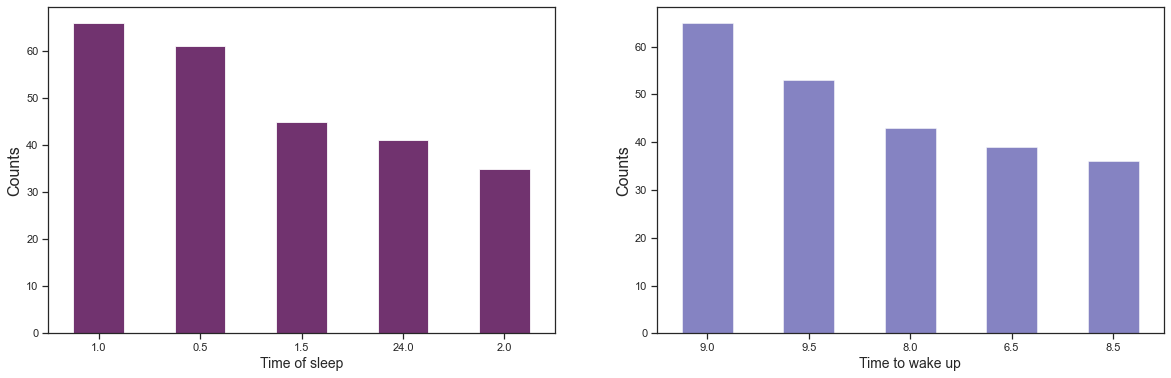

In [292]:
sleep_divisions4['timeInBed'] = sleep_divisions4['timeInBed']/60

#sleepBDF.groupby(['Sleep Bucket']).mean()
#sleepBDF.describe().transpose()

## plot the sleep and awake counts
fig = plt.figure(figsize = (20,6))

ax = plt.subplot(121)  
pd.value_counts(sleep_divisions4['Sleep Bucket']).nlargest(5).plot.bar(cmap="BuPu_r", alpha=0.8)
plt.xlabel('Time of sleep', fontsize=14)
plt.ylabel('Counts', fontsize=16)
plt.xticks(rotation=0)

#############

ax2 = fig.add_subplot(122)
pd.value_counts(sleep_divisions4['Awake Bucket']).nlargest(5).plot.bar(cmap="plasma", alpha=0.5)
plt.xlabel('Time to wake up', fontsize=14)
plt.ylabel('Counts', fontsize=16)
plt.xticks(rotation=0)
plt.show()

This analysis is turning out to be an indictment of sorts. Although the conclusion of these visuals will force me to improve my sleeping habits but, like I said before, this analysis is as good as the sleep data. Which, in this case, is not too accurate from my experience of using the Fitbit app. This may not be accurate as I noticed some time zone issues in the data as I moved countries in 2021.

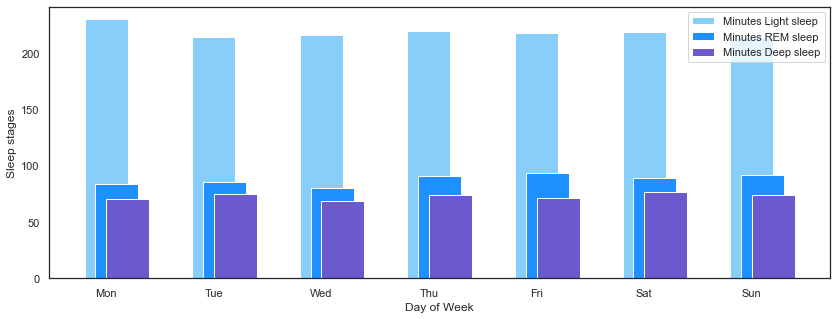

In [205]:
fig = plt.figure(figsize = (14,5))
plt.bar((all_merged_avg.index), all_merged_avg['light'],width = 0.4, color='lightskyblue', label="Minutes Light sleep", tick_label=minDayCodes[1:])
plt.bar((all_merged_avg.index + 0.1), all_merged_avg['rem'], width = 0.4, color='dodgerblue', label="Minutes REM sleep")
plt.bar((all_merged_avg.index + 0.2), all_merged_avg['deep'], width = 0.4, color='slateblue', label="Minutes Deep sleep")
plt.xlabel('Day of Week')
plt.ylabel('Sleep stages')
plt.legend()

Pretty consistent breakdown of sleep stages by the day of the week.

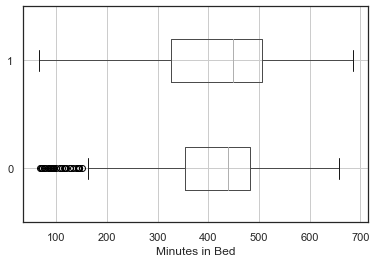

In [207]:
ax = all_merged.boxplot(column = 'timeInBed', by = 'is_weekend', vert = False, widths = 0.4)
plt.xlabel('Minutes in Bed')
plt.suptitle('')
plt.title('');

Slightly higher median value of 'time in bed' (this includes time slept in various sleeping stages combined) is noticed on weekends which is understandable.

Text(111.453125, 0.5, 'Day of the Week \n')

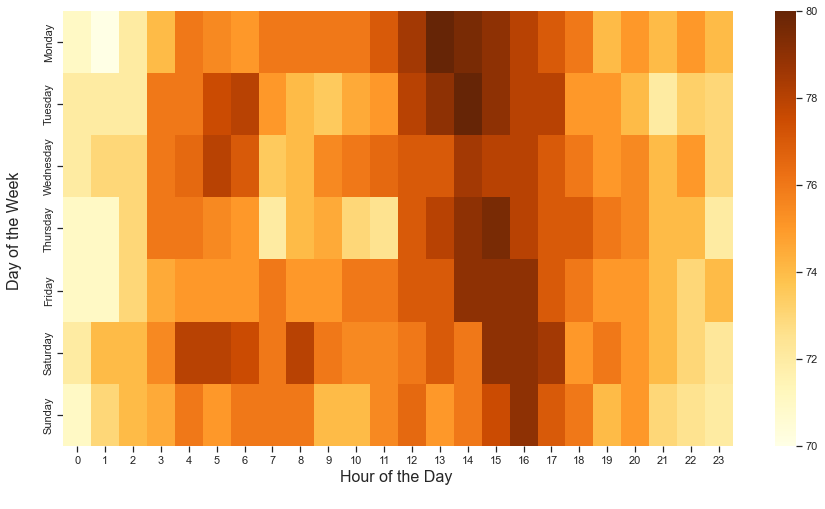

In [282]:
# day of week / hour trends
df_heatmap = heart_rate_df_hour2.copy()
days = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_heatmap['day_of_week'] = df_heatmap['Date'].dt.day_name()
df_heatmap2 = df_heatmap.groupby(['Hour of day','day_of_week'])["bpm"].median()
df_heatmap2 = df_heatmap2.unstack(level=0)
df_heatmap2

# heatmap by day of week and hour

f, ax = plt.subplots(figsize=(15, 8))
sns.color_palette("YlOrBr", as_cmap=True)

#reorderlist = [ 'Monday', 'Tuesday','Wednesday' ,'Thursday' ,'Friday', 'Saturday', 'Sunday']
sns.heatmap(df_heatmap2.reindex(reorderlist), cmap="YlOrBr")

plt.xlabel('Hour of the Day \n', fontsize=16)
plt.ylabel('Day of the Week \n', fontsize=16)

#plt.title('Heatmap of Heartbeat', fontsize=20)

This heatmap shows my median heart beats per minute for each hour of the day separated by day of the week. It is quite useful and I see that there is just one dark red on Sundays at 4 pm. Otherwise, the heart bpm stay below 78 bpm.

Text(0.5, 1.0, 'Sleep Duration by Day')

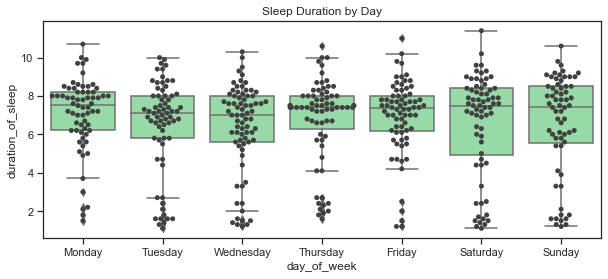

In [236]:
f, ax = plt.subplots(figsize=(10, 4))
sns.set_theme(style="ticks", palette="pastel")

reorderlist = [ 'Monday', 'Tuesday','Wednesday' ,'Thursday' ,'Friday', 'Saturday', 'Sunday']

ax = sns.boxplot(x="day_of_week", y="duration_of_sleep", data=all_merged, order=reorderlist, palette=["g"])
ax = sns.swarmplot(x="day_of_week", y="duration_of_sleep", data=all_merged, order=reorderlist, color=".25")

plt.title('Sleep Duration by Day')

Text(0.5, 1.0, 'Sleep Score by Day')

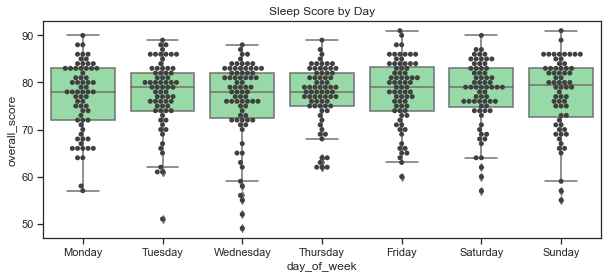

In [238]:
f, ax = plt.subplots(figsize=(10, 4))
sns.set_theme(style="ticks", palette="pastel")

reorderlist = [ 'Monday', 'Tuesday','Wednesday' ,'Thursday' ,'Friday', 'Saturday', 'Sunday']
ax = sns.boxplot(x="day_of_week", y="overall_score", data=all_merged, order=reorderlist, palette=["g"])
ax = sns.swarmplot(x="day_of_week", y="overall_score", data=all_merged, order=reorderlist, color=".25")

plt.title('Sleep Score by Day')

These two visuals just give us further corroboration that the sleep duration and sleep scores are overall pretty consistent although the variability is pretty clear from the boxplots.

## ML Modelling <a class="anchor" id="fifth-bullet"></a>


What parameters are most important for a deep sleep? 




In [322]:
all_merged2 = all_merged.merge(sleep_divisions4[['Date','Sleep Bucket']], how = 'left', on = 'Date') #to utilize the last two columns for modelling
all_merged2 = all_merged2.dropna() # 18 NaN values in Sleep Bucket
all_merged2.head() # Now 467 rows of data without null values

,Date,Resting heart rate,bpm,below_fat_burn_zone,fat_burn_zone,cardio_zone,peak_zone,steps,calories,distance_km,sedentary mins,light active mins,mod active mins,very active mins,duration_of_sleep,minutesToFallAsleep,minutesAsleep,minutesAwake,minutesAfterWakeup,timeInBed,deep,wake,light,rem,overall_score,composition_score,revitalization_score,duration_score,deep_sleep_in_minutes,resting_heart_rate,restlessness,day_of_week,is_weekend,Sleep Bucket
1,2021-01-02,68,76,1215,73,0,0,5606,2554,4.10,791,204,13,0,7.20,0.00,369.00,63.00,0.00,432.00,86.00,63.00,198.00,85.00,74.00,21.00,18.00,35.00,86.00,70.00,0.13,Saturday,1,1.00
2,2021-01-03,69,78,1293,129,0,0,5079,2682,3.70,699,247,0,0,8.20,0.00,452.00,42.00,0.00,494.00,93.00,42.00,218.00,141.00,80.00,22.00,16.00,42.00,92.00,68.00,0.10,Sunday,1,1.00
3,2021-01-04,71,78,1315,82,19,2,3236,2595,2.30,871,139,4,29,6.60,0.00,369.00,28.00,0.00,397.00,81.00,28.00,187.00,101.00,77.00,21.00,17.00,39.00,80.00,69.00,0.05,Monday,0,2.00
4,2021-01-05,73,79,1407,23,0,0,1220,2055,0.80,581,56,0,0,1.60,0.00,97.00,2.00,0.00,99.00,57.00,40.00,173.00,68.00,77.00,22.00,11.00,44.00,105.00,71.00,0.14,Tuesday,0,22.50
5,2021-01-06,73,76,1376,57,2,0,2653,2254,1.90,581,129,0,0,6.10,0.00,348.00,17.00,0.00,365.00,57.00,40.00,173.00,68.00,77.00,22.00,18.00,37.00,102.00,73.00,0.07,Wednesday,0,3.50


In [372]:
# Importing the Scikit learn package and methods
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Defining response and independent variables
y = all_merged2['deep']
X = all_merged2[['bpm','Resting heart rate','calories', 'steps', 'sedentary mins', 'light active mins'
                 , 'mod active mins', 'very active mins', 'duration_of_sleep', 'Sleep Bucket', 'day_of_week']]

# Encoding the the categorical values
X = pd.get_dummies(X, columns=['day_of_week', 'Sleep Bucket'])

# Splitting the data into 75% train and 25% test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=605)
print('X shape: {}'.format(X.shape))
print('Y shape: {}'.format(y.shape))

# Linear Regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
lr_y_pred = regr.predict(X_test)
                        
print("Mean squared error: %.2f"% mean_squared_error(y_test, lr_y_pred))
coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(regr.coef_))], axis = 1)
coefficients.head(10)

X shape: (467, 50)
Y shape: (467,)
Mean squared error: 404.98


,0,0
0,bpm,0.11
1,Resting heart rate,0.12
2,calories,0.01
3,steps,0.00
4,sedentary mins,-0.01
5,light active mins,-0.06
6,mod active mins,-0.00
7,very active mins,-0.22
8,duration_of_sleep,7.56
9,day_of_week_Friday,-2.67


We notice first 3 positive coefficents indicating positive relation between deep sleep and heart rate, resting heart rate and calories. Neutral relation with steps. Slight negative relation with the gradations of active and sedentary minutes. The strongest positive relation is between duration of sleep and deep sleep which is obvious.

In [373]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV
xgb.set_config(verbosity=0)

xgbR = XGBRegressor()
parameters = {'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07, 0.1],
              'max_depth': [3, 4, 5, 6],
              'min_child_weight': [1, 5, 10],
              'silent': [1],
              'n_estimators': [100, 300, 500],
              'seed': [605]
             }

xgb_grid = GridSearchCV(xgbR, parameters, n_jobs = 5, verbose=True)
xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

y_pred = xgb_grid.predict(X_test)
print ("RMSE : ",mean_squared_error(y_test,y_pred))
print("The mean squared error has reduced compared to before")

Fitting 5 folds for each of 144 candidates, totalling 720 fits
0.3746721906362035
{'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 10, 'n_estimators': 100, 'objective': 'reg:linear', 'seed': 605, 'silent': 1}
RMSE :  374.06700700221063
The mean squared error has reduced compared to before
[10:51:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[10:51:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[10:51:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[10:51:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-1

[10:51:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[10:51:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[10:51:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[10:51:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[10:51:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squareder

[10:51:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[10:51:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[10:51:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[10:51:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[10:51:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squareder

In [349]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation on the XGBRegressor model with best hyperparameters
scores = cross_val_score(xgb_grid.best_estimator_, X_train, y_train, cv=5)
print("Cross-validation scores:", scores)
print("Mean cross-validation score:", scores.mean())

Cross-validation scores: [0.53348653 0.43725374 0.34308956 0.38814815 0.17138297]
Mean cross-validation score: 0.3746721906362035


Through XGboost library, we run linear regression again and find that due to parameter tuning, we were able to get a RMSE of 374 mins compared to 404 mins before. It is still pretty high but slightly better tuned model. Let's see what this model says are the most important features for a deep sleep.

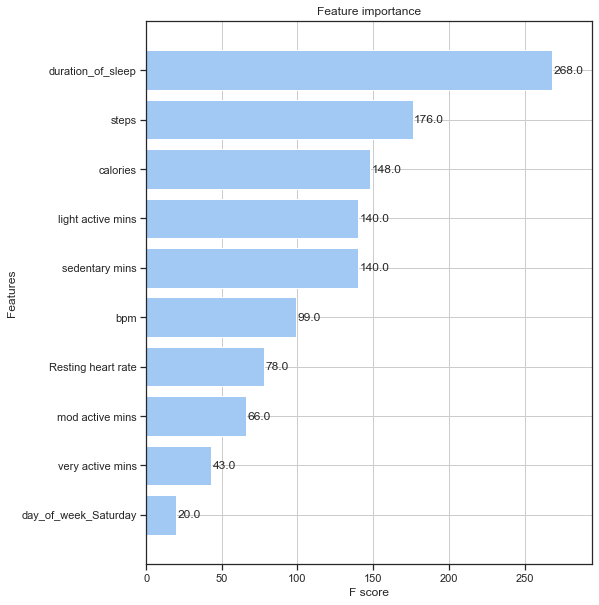

In [369]:
# Showing only the top 10 important features for our response variable 'deep'
fig, ax = plt.subplots(figsize=(8,10))
xgb.plot_importance(xgb_grid.best_estimator_, height=0.8, ax=ax, max_num_features=10)
plt.show()

Pretty understandable that duration of sleep is the most important feature for attaining a higher amount of 'deep' stage of sleep. We also notice higher number of steps (which cause higher burning of calories) are very important for deep sleep. Higher exercise will also lead to higher heart rate and active minutes which are in the top 10 features here. Saturday is also in the top 10 which is not surprising. Weekend is a good proponent of deep sleep

In [374]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import graphviz 



def trainAndPredict(classifier):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    
    print ("Accuracy : ",accuracy_score(y_test,y_pred)*100)
    print("Report : ",classification_report(y_test, y_pred))
    print("Confusion Matrix: ",confusion_matrix(y_test, y_pred))
    return

def plotGraph(classifier):
    dot_data = tree.export_graphviz(classifier, out_file=None, 
                         feature_names=X.columns.values,  
                         class_names=['Yes', 'No'],                                
                         filled=True, rounded=True,  
                         special_characters=True)  
    graph = graphviz.Source(dot_data)  
    return graph

In [378]:
X = all_merged2[['bpm','Resting heart rate','calories', 'steps', 'light active mins'
                 , 'mod active mins', 'very active mins', 'duration_of_sleep', 'Sleep Bucket']]

Y = all_merged2['overall_score'] > 60

print('X shape: {}'.format(X.shape))
print('Y shape: {}'.format(Y.shape))

X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.25, random_state = 605)
print('X_train shape: {}. X_test shape: {}'.format(X_train.shape, X_test.shape))

X shape: (467, 9)
Y shape: (467,)
X_train shape: (350, 9). X_test shape: (117, 9)


Accuracy :  90.5982905982906
Report :                precision    recall  f1-score   support

       False       0.00      0.00      0.00         6
        True       0.95      0.95      0.95       111

    accuracy                           0.91       117
   macro avg       0.47      0.48      0.48       117
weighted avg       0.90      0.91      0.90       117

Confusion Matrix:  [[  0   6]
 [  5 106]]


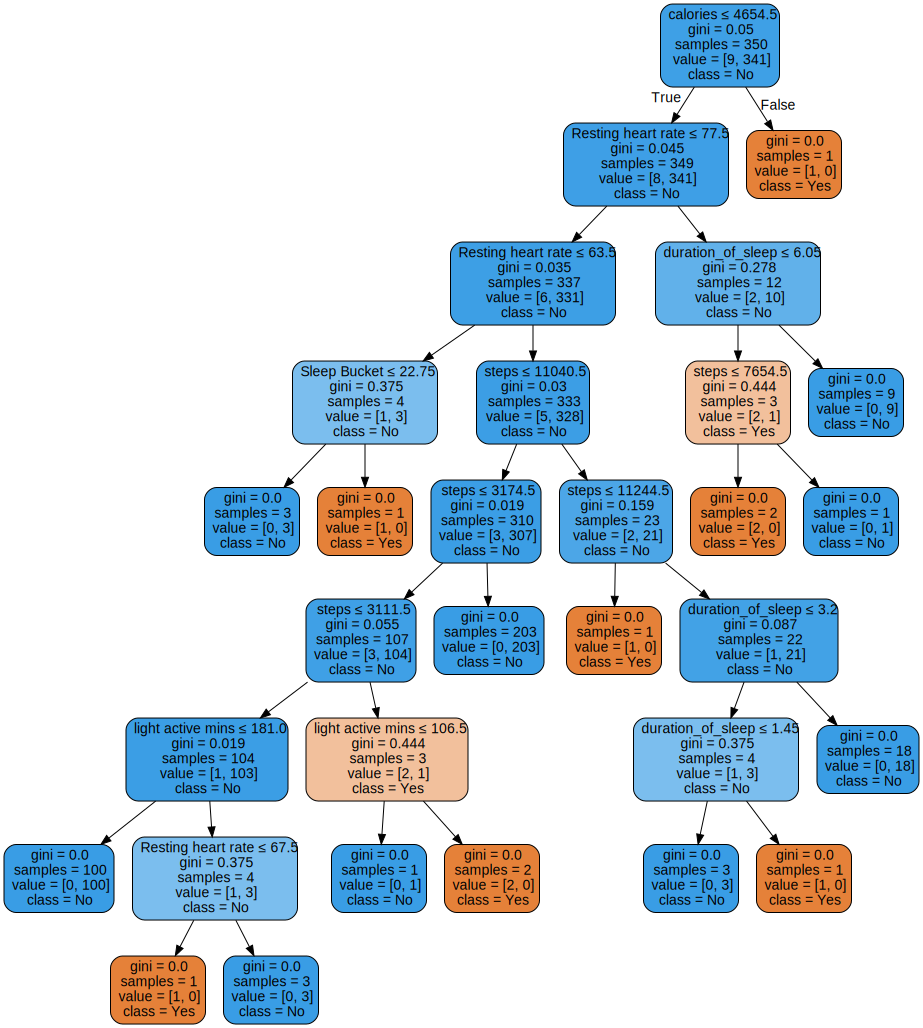

In [379]:
clf_gini_default = DecisionTreeClassifier(criterion = "gini")
trainAndPredict(clf_gini_default)
plotGraph(clf_gini_default)

To get a higher Fitbit generated 'sleep score' (Rated out of 100), it appears from the decision tree that very active minutes must be less than 177 mins (which is usually the case) and then a lower resting heart rate than 63.5 bpm (and heart rate in general) and steps are crucial for the sleep score. 

## References <a class="anchor" id="sixth-bullet"></a>

- Tanuwidjaja, O. (2022) *Evaluating my fitness by analyzing my Fitbit data archive*, *Medium*. Available at: https://towardsdatascience.com/evaluating-my-fitness-by-analyzing-my-fitbit-data-archive-23a123baf349 (Accessed: February 7, 2023).
- Ottensen, C. (2019) *Tutorial: Making sense of Fitbits’s JSON export*, *Dataespresso*. Available at: https://dataespresso.com/en/2019/02/07/fitbit-json-to-csv/ (Accessed: February 1, 2023).
- Eady, A. (2020) *Going deep with Tableau Tooltips: Adding images*, *interworks.com*. . Available at: https://interworks.com/blog/2020/09/11/going-deep-with-tableau-tooltips-adding-images/ (Accessed: February 14, 2023).
- Shaffer, J. (2017) *How to add an animated GIF to your Tableau viz (and make it rain)*, *tableau.com*. Available at: https://www.tableau.com/blog/10-tips-creating-rainy-day-viz-tableau-64385 (Accessed: February 14, 2023).